# Fingerprint-based similarity scores - exploring log scaling and IDF

## Challenge
1. The commonly used fingerprints (Morgan, rdkit etc.) all count every bit equally, no matter how rare or common the underlying structure is.
2. Count vectors *can* have the tendency to "over-react" on some smaller bits that might occur in very high numbers (such as a "-C-" sequence in lipids).

Data:

Compare multiple fingerprints on the "ms2 structures" dataset [Bushuiev 2024].

In [73]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [74]:
filename = "compounds_unique_inchikey14.pickle"
compounds = pd.read_pickle(os.path.join(path_data, filename))
compounds.head()

,inchikey,inchi,smiles,spectrum_id
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862


In [84]:
def idf_normalized(df, N):
    def formula(x, N):
        return np.log(N / x)
    max_idf = formula(1, N)
    return formula(df, N) / max_idf

In [75]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

def calculate_mass(smiles):
    # Convert SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return "Invalid SMILES"
    # Calculate the molecular mass
    mass = Descriptors.MolWt(molecule)
    return mass

In [76]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

  0%|          | 0/37663 [00:00<?, ?it/s]

In [5]:
compounds["mass"] = masses
compounds.head()

,inchikey,inchi,smiles,spectrum_id,mass
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None,423.904
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None,324.383
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250,427.494
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357,280.327
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862,314.340


In [77]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator, SparseFingerprintGenerator, compute_fingerprints_from_smiles
from metrics import ruzicka_similarity_matrix_sparse, jaccard_similarity_matrix_sparse

In [22]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_sparse = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=True, sparse=True, progress_bar=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 37663/37663 [00:06<00:00, 6168.51it/s]


# Count fingerprint bits

In [80]:
from fingerprint_computation import count_fingerprint_keys

In [24]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan3_sparse[:100])

CPU times: user 8.07 ms, sys: 10 ms, total: 18.1 ms
Wall time: 17.9 ms


In [25]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan3_sparse)

CPU times: user 621 ms, sys: 967 μs, total: 622 ms
Wall time: 621 ms


In [26]:
unique_keys.shape, counts.shape, first_instances.shape

((291010,), (291010,), (291010,))

In [27]:
counts.max(), counts.min()

(np.int32(30953), np.int32(1))

In [28]:
# Counts == 1 could later be discarded!
(counts == 1).sum()

np.int64(179155)

In [25]:
(counts <= 2).sum()

np.int64(221808)

In [28]:
idf_normalized(2, 37663)

np.float64(0.9342142497034746)

In [30]:
idx = np.where(counts > 1)[0]
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
})

,bit,count
0,34552,3
1,59974,3
2,79728,7
3,93098,2
4,96188,7
...,...,...
111850,4294701792,2
111851,4294707339,8
111852,4294751024,2
111853,4294767870,4


In [31]:
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
}).to_csv("bit_counts_ms2structures_morgan3.csv")

In [29]:
num_compounds = len(fingerprints_morgan3_sparse)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [30]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_ms2structures_morgan3.csv")

## Inspect the most common bits

In [16]:
def get_substructure_smiles(mol, atom_idx, radius):
    if radius == 0:
        # Create a single-atom submolecule for radius=0
        atom = mol.GetAtomWithIdx(atom_idx)
        submol = Chem.RWMol(Chem.Mol())
        new_idx = submol.AddAtom(atom)
        amap = {atom_idx: new_idx}
        subsmiles = Chem.MolToSmiles(submol)
    else:
        # Get the atom environment for the given radius
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
        if not env:
            return None  # Handle cases where no environment is found
        amap = {}
        submol = Chem.PathToSubmol(mol, env, atomMap=amap)
        #display(submol)
        #Chem.Kekulize(submol)
        subsmiles = Chem.MolToSmiles(submol, allBondsExplicit=True, allHsExplicit=True)
        #subsmiles = Chem.MolToSmiles(submol)
    return subsmiles

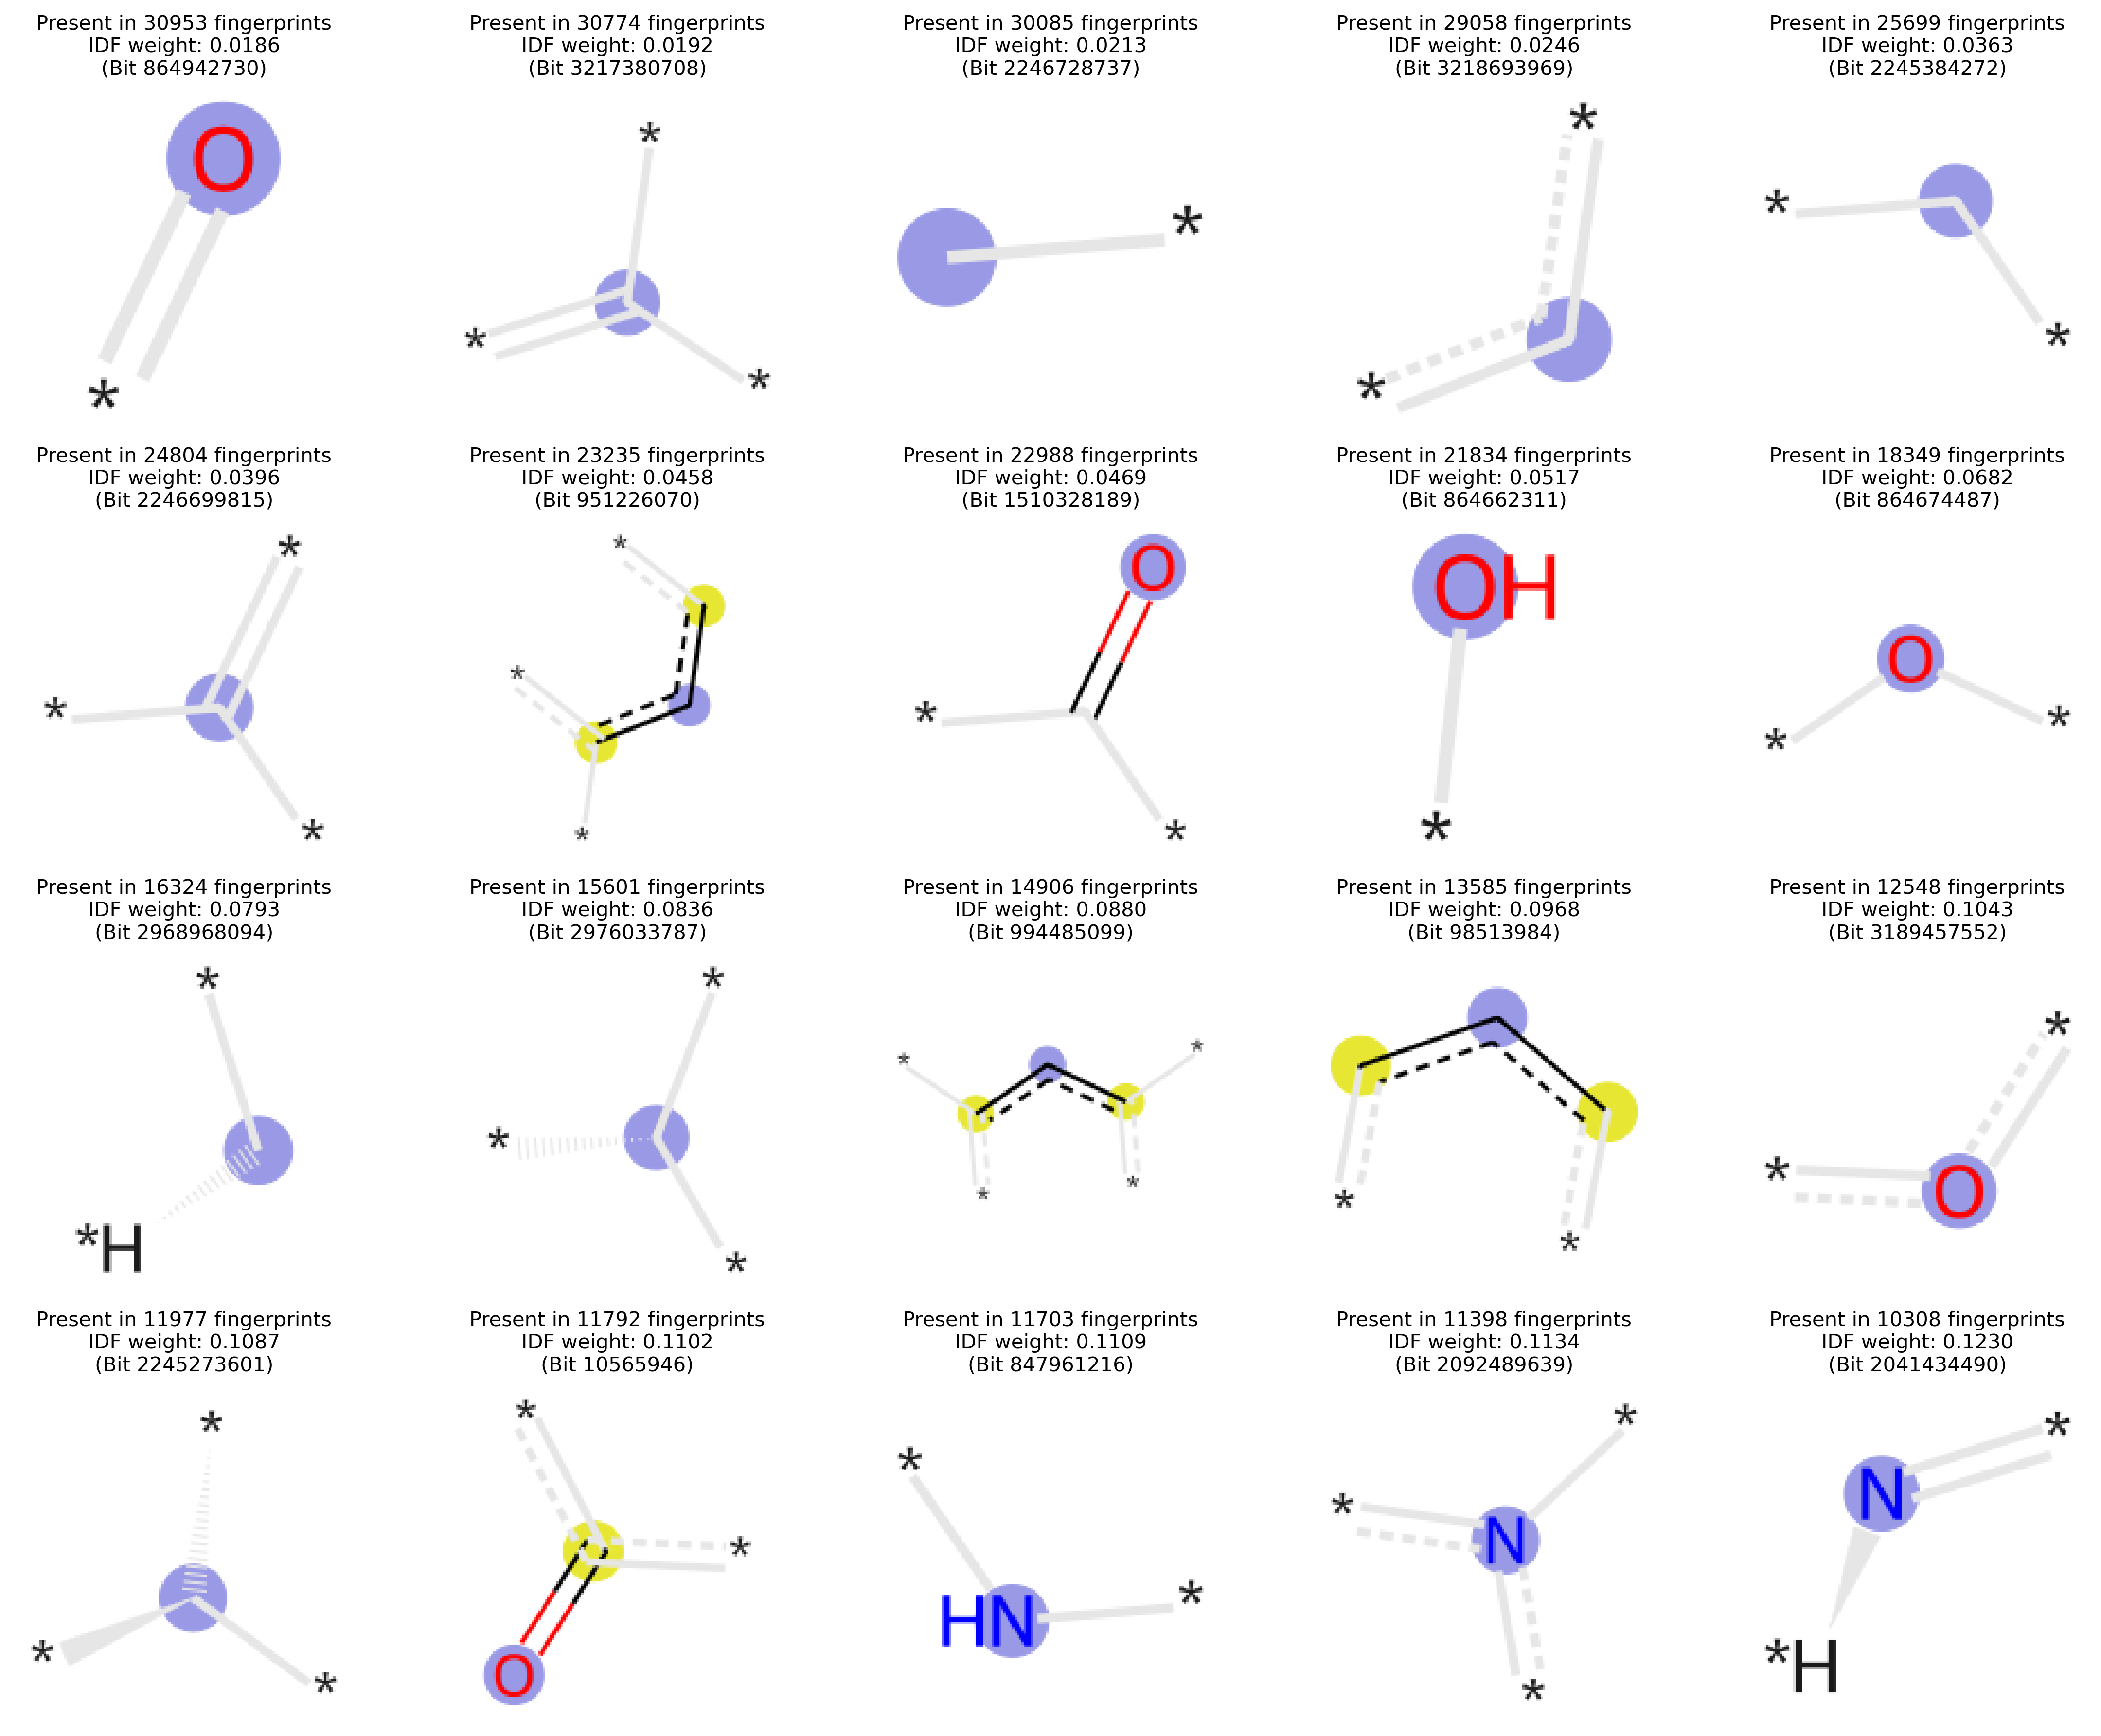

In [22]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import AllChem
import pandas as pd

# Assuming `unique_keys`, `idx_sorted`, `counts`, `compounds`, `fingerprints`, and helper functions are already defined
fpgen = AllChem.GetMorganGenerator(radius=3)

# Initialize data storage for frequent bits
frequent_bits = {
    "counts": [],
    "radius": [],
    "subsmiles": [],
    "bit_id": [],
    "mol_images": [],
}
mol_svgs = []
images = []

idx_sorted = np.argsort(counts)[::-1]


# Process top 20 bits
for i, idx in enumerate(idx_sorted[:20]):
    smiles = compounds.smiles[first_instances[idx]]
    mol = Chem.MolFromSmiles(smiles)

    ao = AllChem.AdditionalOutput()
    ao.CollectBitInfoMap()
    fp = fpgen.GetSparseCountFingerprint(mol, additionalOutput=ao)
    bi = ao.GetBitInfoMap()

    if unique_keys[idx] in bi:
        atom_idx, radius = bi[unique_keys[idx]][0]
        frequent_bits["counts"].append(counts[idx])
        frequent_bits["radius"].append(radius)
        frequent_bits["bit_id"].append(unique_keys[idx])
        
        # Generate substructure SMILES
        if radius == 0:
            subsmiles0 = get_substructure_smiles(mol, atom_idx, 0)
            subsmiles1 = get_substructure_smiles(mol, atom_idx, 1)
            frequent_bits["subsmiles"].append(subsmiles0 + " <-- " + subsmiles1)
        else:
            frequent_bits["subsmiles"].append(get_substructure_smiles(mol, atom_idx, radius))

        # Generate image of molecule with highlighted bit
        img = Draw.DrawMorganBit(mol, unique_keys[idx], bi)#, useSVG=True)
        images.append((mol, unique_keys[idx], bi))
        frequent_bits["mol_images"].append(img)
        #mol_svgs.append(img)

# Convert data to DataFrame
frequent_bits_df = pd.DataFrame(frequent_bits)
frequent_bits_df["idf_weight"] = idf_normalized(frequent_bits_df["counts"], len(fingerprints_morgan3_sparse))

# Create grid plot
n_cols = 5
n_rows = (len(frequent_bits_df) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3), dpi=300)

legends = []

for i, ax in enumerate(axes.flatten()):
    if i < len(frequent_bits_df):
        ax.imshow(frequent_bits_df.loc[i, "mol_images"])
        legend = f"Present in {frequent_bits_df.loc[i, 'counts']} fingerprints\nIDF weight: {frequent_bits_df.loc[i, 'idf_weight']:.4f}\n(Bit {frequent_bits_df.loc[i, 'bit_id']})"
        legends.append(legend)
        ax.set_title(legend, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig("most_frequent_bits_Morgan3.png", dpi=300)
plt.show()

## Morgan-9

In [78]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)

fingerprints_morgan9_sparse = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=True, sparse=True, progress_bar=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 37663/37663 [00:09<00:00, 4103.80it/s]


In [81]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan9_sparse)

CPU times: user 2min 26s, sys: 125 ms, total: 2min 26s
Wall time: 2min 26s


In [82]:
unique_keys.shape, counts.shape, first_instances.shape, counts.max(), counts.min()

((1077458,), (1077458,), (1077458,), np.int32(30953), np.int32(1))

In [83]:
idx = np.where(counts > 1)[0]
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
}).to_csv("bit_counts_ms2structures_morgan9.csv")

In [85]:
num_compounds = len(fingerprints_morgan9_sparse)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [86]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_ms2structures_morgan9.csv")

# Now run this on the biostructures dataset!

In [3]:
filename = "biostructures.csv"
compounds = pd.read_csv(os.path.join(path_data, "fleming_data", filename))
compounds = compounds.set_index("inchi_key_1")

print(compounds.shape)
compounds.head()

(718097, 1)


,smiles
inchi_key_1,
KFDYZSPFVRTLML,C1COCCN1C2=NC(=NC(=N2)NC3=CC(=C(C=C3)C=CC4=C(C...
HINREHSUCWWBNO,CCOC1=C(C=CC(=C1)C=NNC(=O)COC2=C(C=CC(=C2)C)C(...
XSJXTRKBEZABIM,CCOC1=C(C=CC(=C1)C=NNC(=O)COC2=C(C=CC(=C2)C(C)...
RGEDPHNWBSQUKZ,CC1=CC=CC=C1N2C(=NN=C2SCC(=O)NC3=CC(=C(C=C3)Cl...
RPFGFTBJBUHWDA,CC1=CC=CC=C1N2C(=NN=C2SCC(=O)NC3=C(C=CC=C3Cl)C...


In [4]:
exclude_inchikeys = [
    "XFXAGVXHBIDZJE", "KNSWLJFYTHGVGP", "MIUKAZMTBNWUDP",
    "ROYLRIQYTZJBAR", "KLHDFCUIIHOAIW", "SCMUSNCWPKDKKK", "CGCDOKHAYHELEG", "WONOLTWTXSUXQB", "JOHWNGGYGAVMGU",
    "LRWFHPLMQGPJCY", "KNSWNNXPAWSACI", "AXCBHWGTRNNXKG", "XHFXMNZYIKFCPN", "OSVXSBDYLRYLIG", "TVWHTOUAJSGEKT",
    "AOIWFGJNGXKHGL", "JHNJAVOZJQRGSH", "YXFJCDMOWXLUFT", "ZKIBBIKDPHAFLN", "LTDXHAFASXANOM", "FQFKTKUFHWNTBN", "XHVUVQAANZKEKF",
    "UTRRCWWJXMITGT", "RZPONWCINKBQNQ", "INDBPWPYJQZLTL", "VOGWKIGUWPCLMP",
    "YBNISKWFKJBFGP", "ITGROQVHGXJRIY", "CBHMIKMVVKYVSV", "JIVGQESTRBEXGT",
]

compounds = compounds.drop(exclude_inchikeys)

print(f"Number of unique compounds (according to Inchikey14): {pd.unique(compounds.index).shape[0]}.")

Number of unique compounds (according to Inchikey14): 718067.


In [35]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_biostructures = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=True, sparse=True, progress_bar=True
)

 21%|██████████████████▏                                                                    | 150087/718067 [00:38<00:41, 13713.35it/s][16:08:54] WARNING: not removing hydrogen atom without neighbors
[16:08:54] WARNING: not removing hydrogen atom without neighbors
[16:08:54] WARNING: not removing hydrogen atom without neighbors
100%|████████████████████████████████████████████████████████████████████████████████████████| 718067/718067 [02:11<00:00, 5453.68it/s]


In [44]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan3_biostructures, max_keys=10**8)

CPU times: user 25min 20s, sys: 2.14 s, total: 25min 22s
Wall time: 25min 19s


In [45]:
unique_keys.shape, counts.shape, first_instances.shape

((2220800,), (2220800,), (2220800,))

In [46]:
counts.max()

np.int32(578759)

In [47]:
idx = np.where(counts > 1)[0]
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
})

,bit,count
0,368,10
1,676,4
2,1040,2
3,9403,2
4,13347,6
...,...,...
982543,4294947328,2
982544,4294949385,3
982545,4294957949,4
982546,4294958106,6


In [48]:
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
}).to_csv("bit_counts_biostructures_morgan3.csv")

In [52]:
idx = np.where(counts > 1)[0]

pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx],
    "first_instance": first_instances[idx]
}).to_csv("bit_counts_biostructures_morgan3_w_first_instance.csv")

/tmp/ipykernel_850572/2701014453.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  smiles = compounds.smiles[first_instances[idx]]


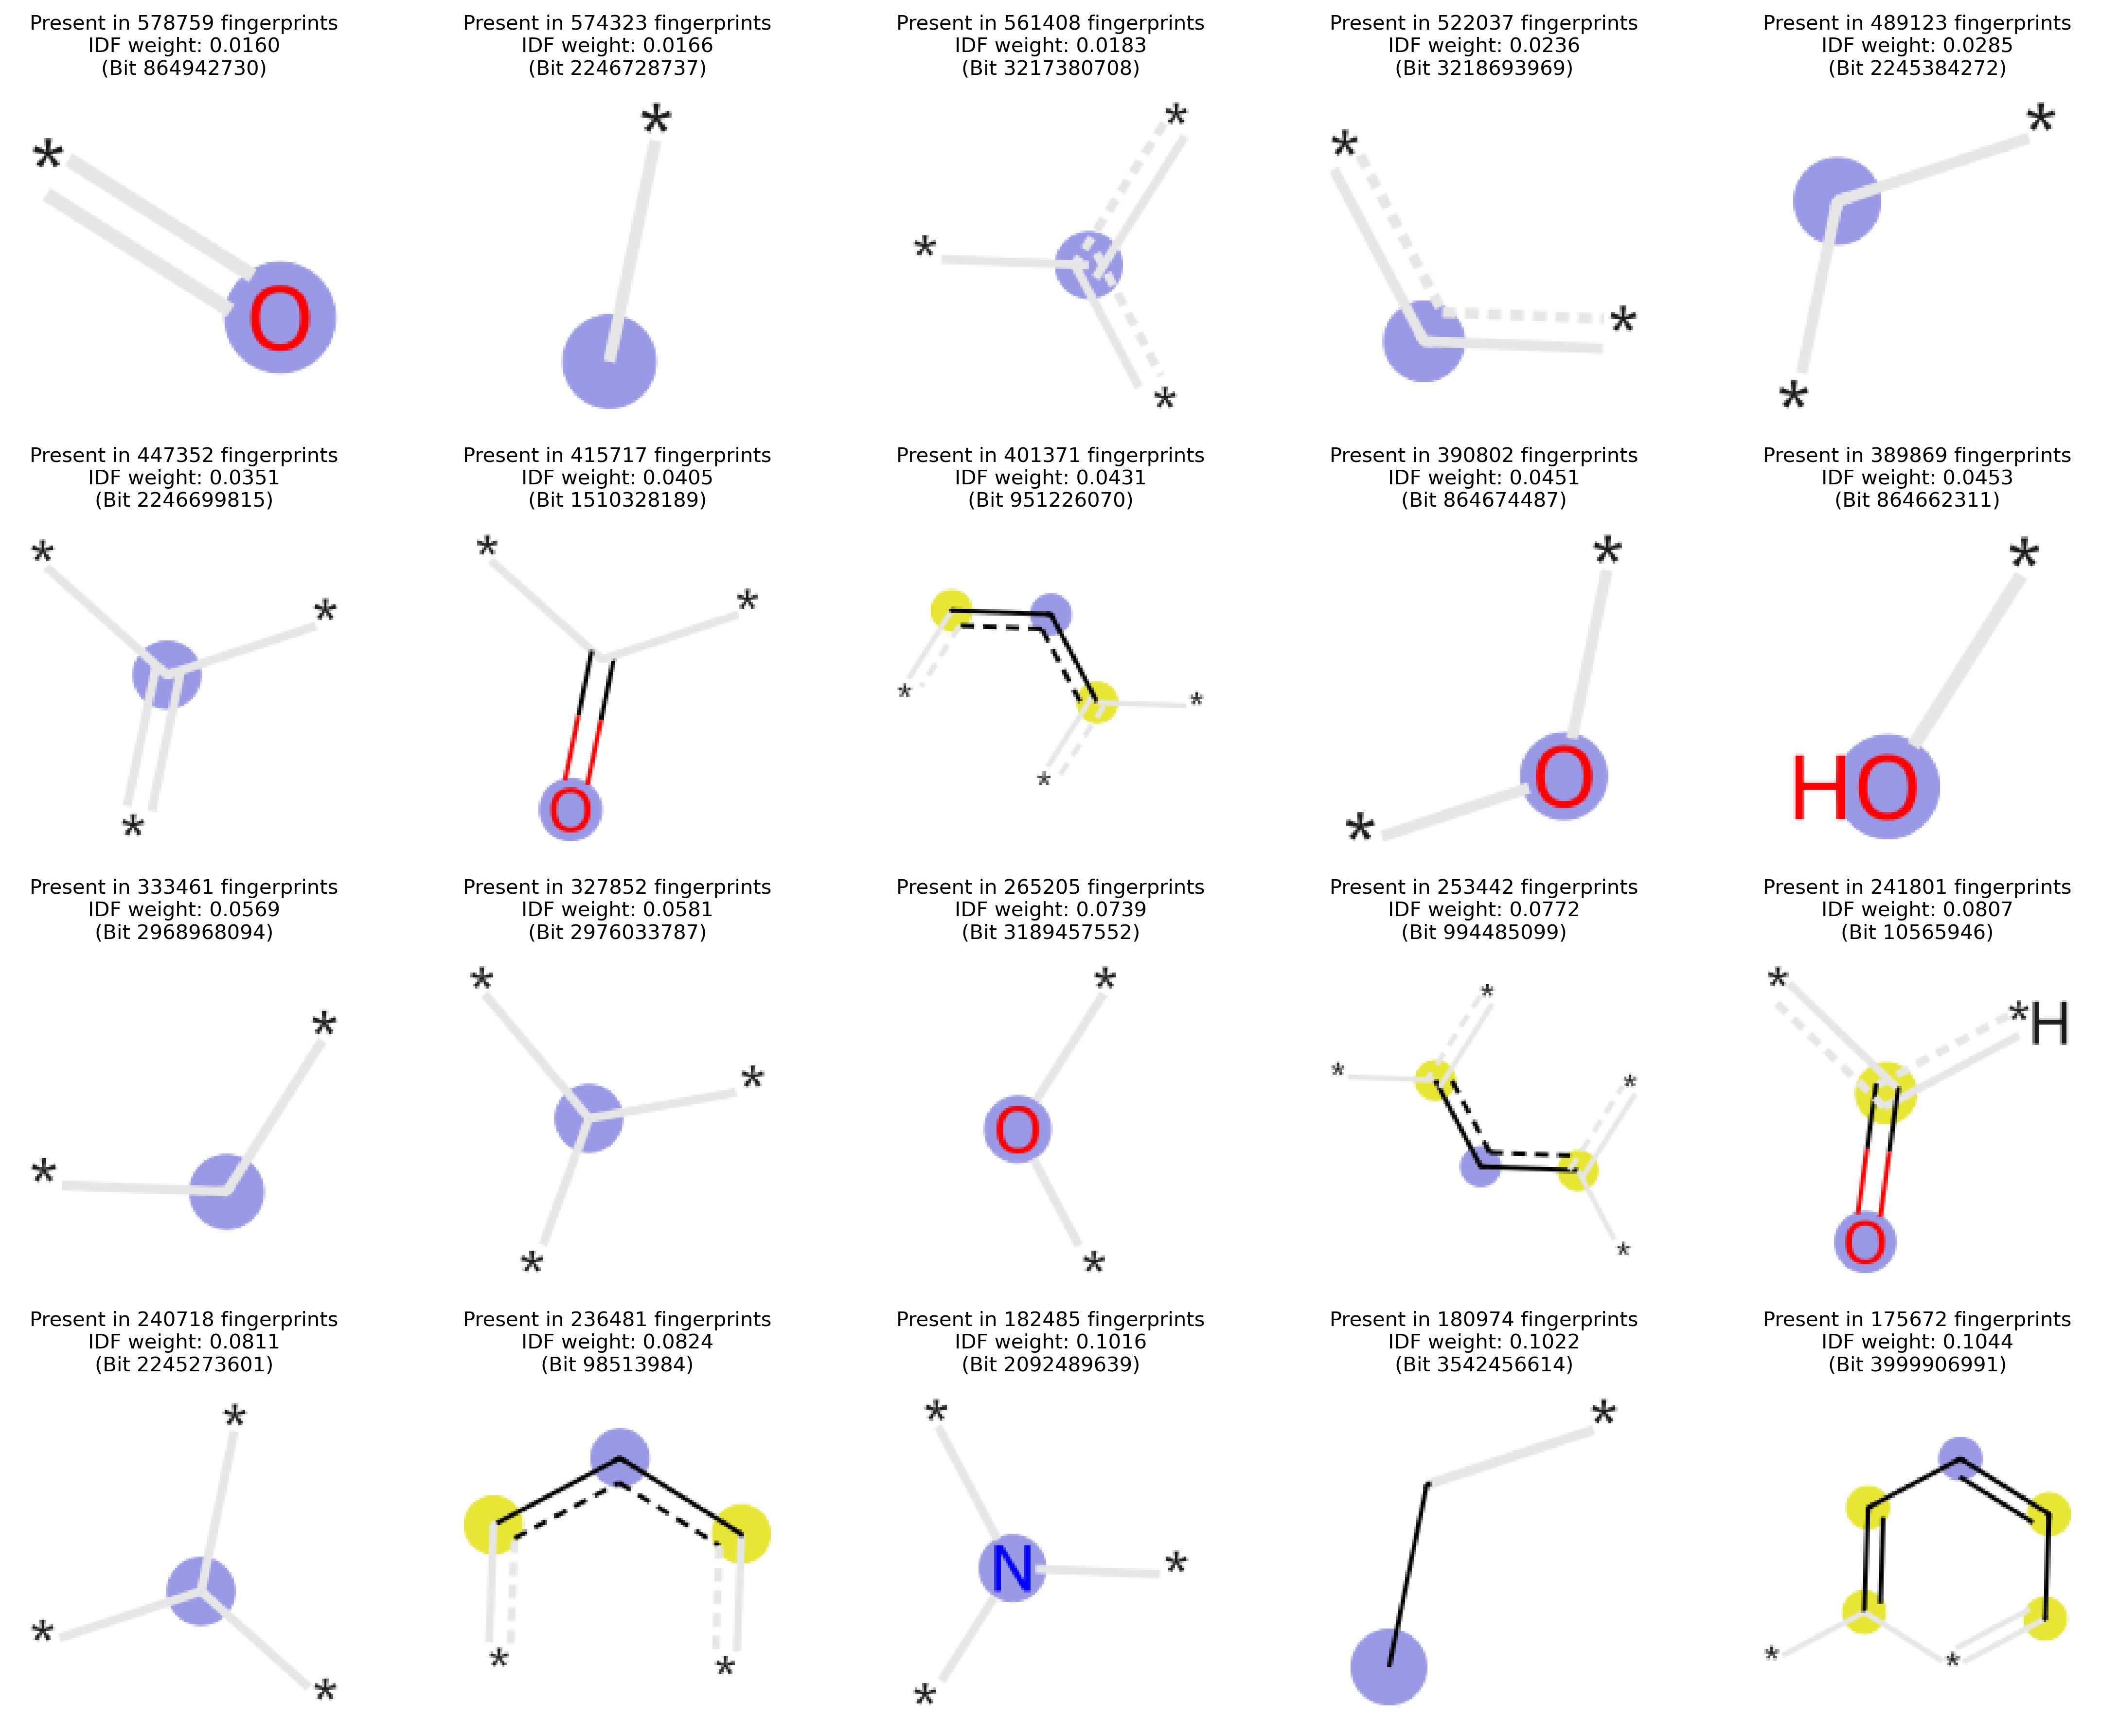

In [49]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import AllChem
import pandas as pd

# Assuming `unique_keys`, `idx_sorted`, `counts`, `compounds`, `fingerprints`, and helper functions are already defined
fpgen = AllChem.GetMorganGenerator(radius=3)

# Initialize data storage for frequent bits
frequent_bits = {
    "counts": [],
    "radius": [],
    "subsmiles": [],
    "bit_id": [],
    "mol_images": [],
}
mol_svgs = []
images = []

idx_sorted = np.argsort(counts)[::-1]


# Process top 20 bits
for i, idx in enumerate(idx_sorted[:20]):
    smiles = compounds.smiles[first_instances[idx]]
    mol = Chem.MolFromSmiles(smiles)

    ao = AllChem.AdditionalOutput()
    ao.CollectBitInfoMap()
    fp = fpgen.GetSparseCountFingerprint(mol, additionalOutput=ao)
    bi = ao.GetBitInfoMap()

    if unique_keys[idx] in bi:
        atom_idx, radius = bi[unique_keys[idx]][0]
        frequent_bits["counts"].append(counts[idx])
        frequent_bits["radius"].append(radius)
        frequent_bits["bit_id"].append(unique_keys[idx])
        
        # Generate substructure SMILES
        if radius == 0:
            subsmiles0 = get_substructure_smiles(mol, atom_idx, 0)
            subsmiles1 = get_substructure_smiles(mol, atom_idx, 1)
            frequent_bits["subsmiles"].append(subsmiles0 + " <-- " + subsmiles1)
        else:
            frequent_bits["subsmiles"].append(get_substructure_smiles(mol, atom_idx, radius))

        # Generate image of molecule with highlighted bit
        img = Draw.DrawMorganBit(mol, unique_keys[idx], bi)#, useSVG=True)
        images.append((mol, unique_keys[idx], bi))
        frequent_bits["mol_images"].append(img)
        #mol_svgs.append(img)

# Convert data to DataFrame
frequent_bits_df = pd.DataFrame(frequent_bits)
frequent_bits_df["idf_weight"] = idf_normalized(frequent_bits_df["counts"], len(fingerprints_morgan3_biostructures))

# Create grid plot
n_cols = 5
n_rows = (len(frequent_bits_df) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3), dpi=300)

legends = []

for i, ax in enumerate(axes.flatten()):
    if i < len(frequent_bits_df):
        ax.imshow(frequent_bits_df.loc[i, "mol_images"])
        legend = f"Present in {frequent_bits_df.loc[i, 'counts']} fingerprints\nIDF weight: {frequent_bits_df.loc[i, 'idf_weight']:.4f}\n(Bit {frequent_bits_df.loc[i, 'bit_id']})"
        legends.append(legend)
        ax.set_title(legend, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig("most_frequent_bits_Morgan3_biostructures.png", dpi=300)
plt.show()

## Morgan-9

In [9]:
import numba
import numpy as np
from numba import types, typed

@numba.njit
def count_fingerprint_keys(fingerprints):
    """
    Count the occurrences of keys across all sparse fingerprints using two dictionaries
    (one for counts, one for the first fingerprint index) for fast lookup.
    
    Parameters:
        fingerprints (list of tuples): Each tuple contains two numpy arrays:
            (keys, values) for a fingerprint.
    
    Returns:
        A tuple of 3 Numpy arrays (unique_keys, counts, first_instances) where:
            - unique_keys: Sorted unique bit keys.
            - counts: The number of occurrences of each key.
            - first_instances: The first fingerprint index where each key occurred.
    """
    # Create dictionaries with key type int64 and value type int32.
    counts = typed.Dict.empty(key_type=types.int64, value_type=types.int32)
    first_instance = typed.Dict.empty(key_type=types.int64, value_type=types.int32)
    
    # Loop over each fingerprint.
    for i in range(len(fingerprints)):
        keys, _ = fingerprints[i]
        for key in keys:
            if key in counts:
                counts[key] += 1
            else:
                counts[key] = 1
                first_instance[key] = i
    
    # Allocate arrays to hold the results.
    n = len(counts)
    unique_keys = np.empty(n, dtype=np.int64)
    count_arr   = np.empty(n, dtype=np.int32)
    first_arr   = np.empty(n, dtype=np.int32)
    
    # Transfer dictionary contents to arrays.
    idx = 0
    for key in counts:
        unique_keys[idx] = key
        count_arr[idx] = counts[key]
        first_arr[idx] = first_instance[key]
        idx += 1
    
    # Sort by key.
    order = np.argsort(unique_keys)
    return unique_keys[order], count_arr[order], first_arr[order]


In [8]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)

fingerprints_morgan9_biostructures = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=True, sparse=True, progress_bar=True
)

 21%|██████████████████▎                                                                    | 151141/718067 [01:34<00:48, 11785.48it/s][20:22:27] WARNING: not removing hydrogen atom without neighbors
[20:22:27] WARNING: not removing hydrogen atom without neighbors
[20:22:27] WARNING: not removing hydrogen atom without neighbors
100%|████████████████████████████████████████████████████████████████████████████████████████| 718067/718067 [03:49<00:00, 3135.07it/s]


In [12]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan9_biostructures)#, max_keys=10**8)

/tmp/ipykernel_1295692/1252398760.py:30: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  counts[key] += 1


CPU times: user 21.6 s, sys: 762 ms, total: 22.3 s
Wall time: 22.3 s


In [13]:
unique_keys.shape, counts.shape, first_instances.shape, counts.max()

((12318639,), (12318639,), (12318639,), np.int32(578759))

In [14]:
idx = np.where(counts > 1)[0]

pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx],
    "first_instance": first_instances[idx]
}).to_csv("bit_counts_biostructures_morgan9_w_first_instance.csv")

In [17]:
num_compounds = len(fingerprints_morgan9_biostructures)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [18]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_biostructures_morgan9.csv")

In [19]:
(counts == 1).sum()

np.int64(8531739)

## Use bit counts for idf-scaling of bits

In [62]:
unique_keys[:10], unique_keys[-10:]

(array([  368,   676,  1040,  1301,  4370,  4404,  7655,  8269,  9403,
        13347]),
 array([4294947328, 4294948502, 4294949385, 4294952990, 4294953238,
        4294957949, 4294958106, 4294963861, 4294964945, 4294967264]))

In [ ]:
def idf_normalized(df, N):
    def formula(x, N):
        return np.log(N / x)
    max_idf = formula(1, N)
    return formula(df, N) / max_idf

In [55]:
num_compounds = len(fingerprints_morgan3_biostructures)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [64]:
bit_weighing[864942730]

np.float64(0.015994633239014514)

In [71]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_biostructures_morgan3.csv")

In [65]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_sparse = compute_fingerprints_from_smiles(
    compounds.smiles[:1000], fpgen, count=True, sparse=True, progress_bar=True, bit_weighing=bit_weighing
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4513.24it/s]


In [67]:
fingerprints_morgan3_sparse[1]

(array([  93585016,  102492624,  194855659,  422715066,  445431883,
         498730307,  548743766,  573169829,  584823634,  589930590,
         708370251,  730049667,  788839801,  847336149,  847961216,
         864674487,  864942730,  941282395,  950023157,  951226070,
         994485099, 1013267280, 1016841875, 1081231276, 1135286194,
        1143528820, 1266193593, 1310068516, 1490549211, 1510328189,
        1517662977, 1571432276, 1595673428, 1714831564, 1761951119,
        1788699751, 1844294411, 2050509910, 2077658817, 2115476908,
        2132058917, 2180786472, 2245273601, 2245384272, 2246340824,
        2246699815, 2246703798, 2246728737, 2309124039, 2424973678,
        2458968089, 2492789883, 2594220197, 2650699036, 2677858541,
        2713535913, 2788540332, 2827868305, 2829714342, 2931695851,
        2931878080, 2956998777, 3011598321, 3056593145, 3058180405,
        3060172001, 3079735252, 3088822697, 3112905891, 3207567135,
        3217380708, 3218693969, 3315826729, 3347

## Compare IDFs /counts between datasets

In [31]:
bit_weighing_ms2structures = pd.read_csv("bit_weighing_ms2structures_morgan3.csv")
bit_weighing_biostructures = pd.read_csv("bit_weighing_biostructures_morgan3.csv")


In [32]:
bit_weighing_ms2structures.head()

,bit,idf_weighing
0,34552,0.895732
1,59974,0.895732
2,79728,0.815316
3,93098,0.934214
4,96188,0.815316


In [33]:
bit_weighing_biostructures.head()

,bit,idf_weighing
0,368,0.829240
1,676,0.897192
2,1040,0.948596
3,9403,0.948596
4,13347,0.867123


In [35]:
bit_weighing_ms2structures.shape, bit_weighing_biostructures.shape

((111855, 2), (982548, 2))

In [38]:
overlap = np.intersect1d(bit_weighing_biostructures.bit.values,
                     bit_weighing_ms2structures.bit.values)

In [39]:
overlap.shape

(101905,)

In [40]:
overlap[:10]

array([ 34552,  59974,  79728,  93098,  96188, 115440, 150310, 154415,
       179532, 180552])

In [41]:
bit_weighing_ms2structures = bit_weighing_ms2structures.set_index("bit")
bit_weighing_biostructures = bit_weighing_biostructures.set_index("bit")

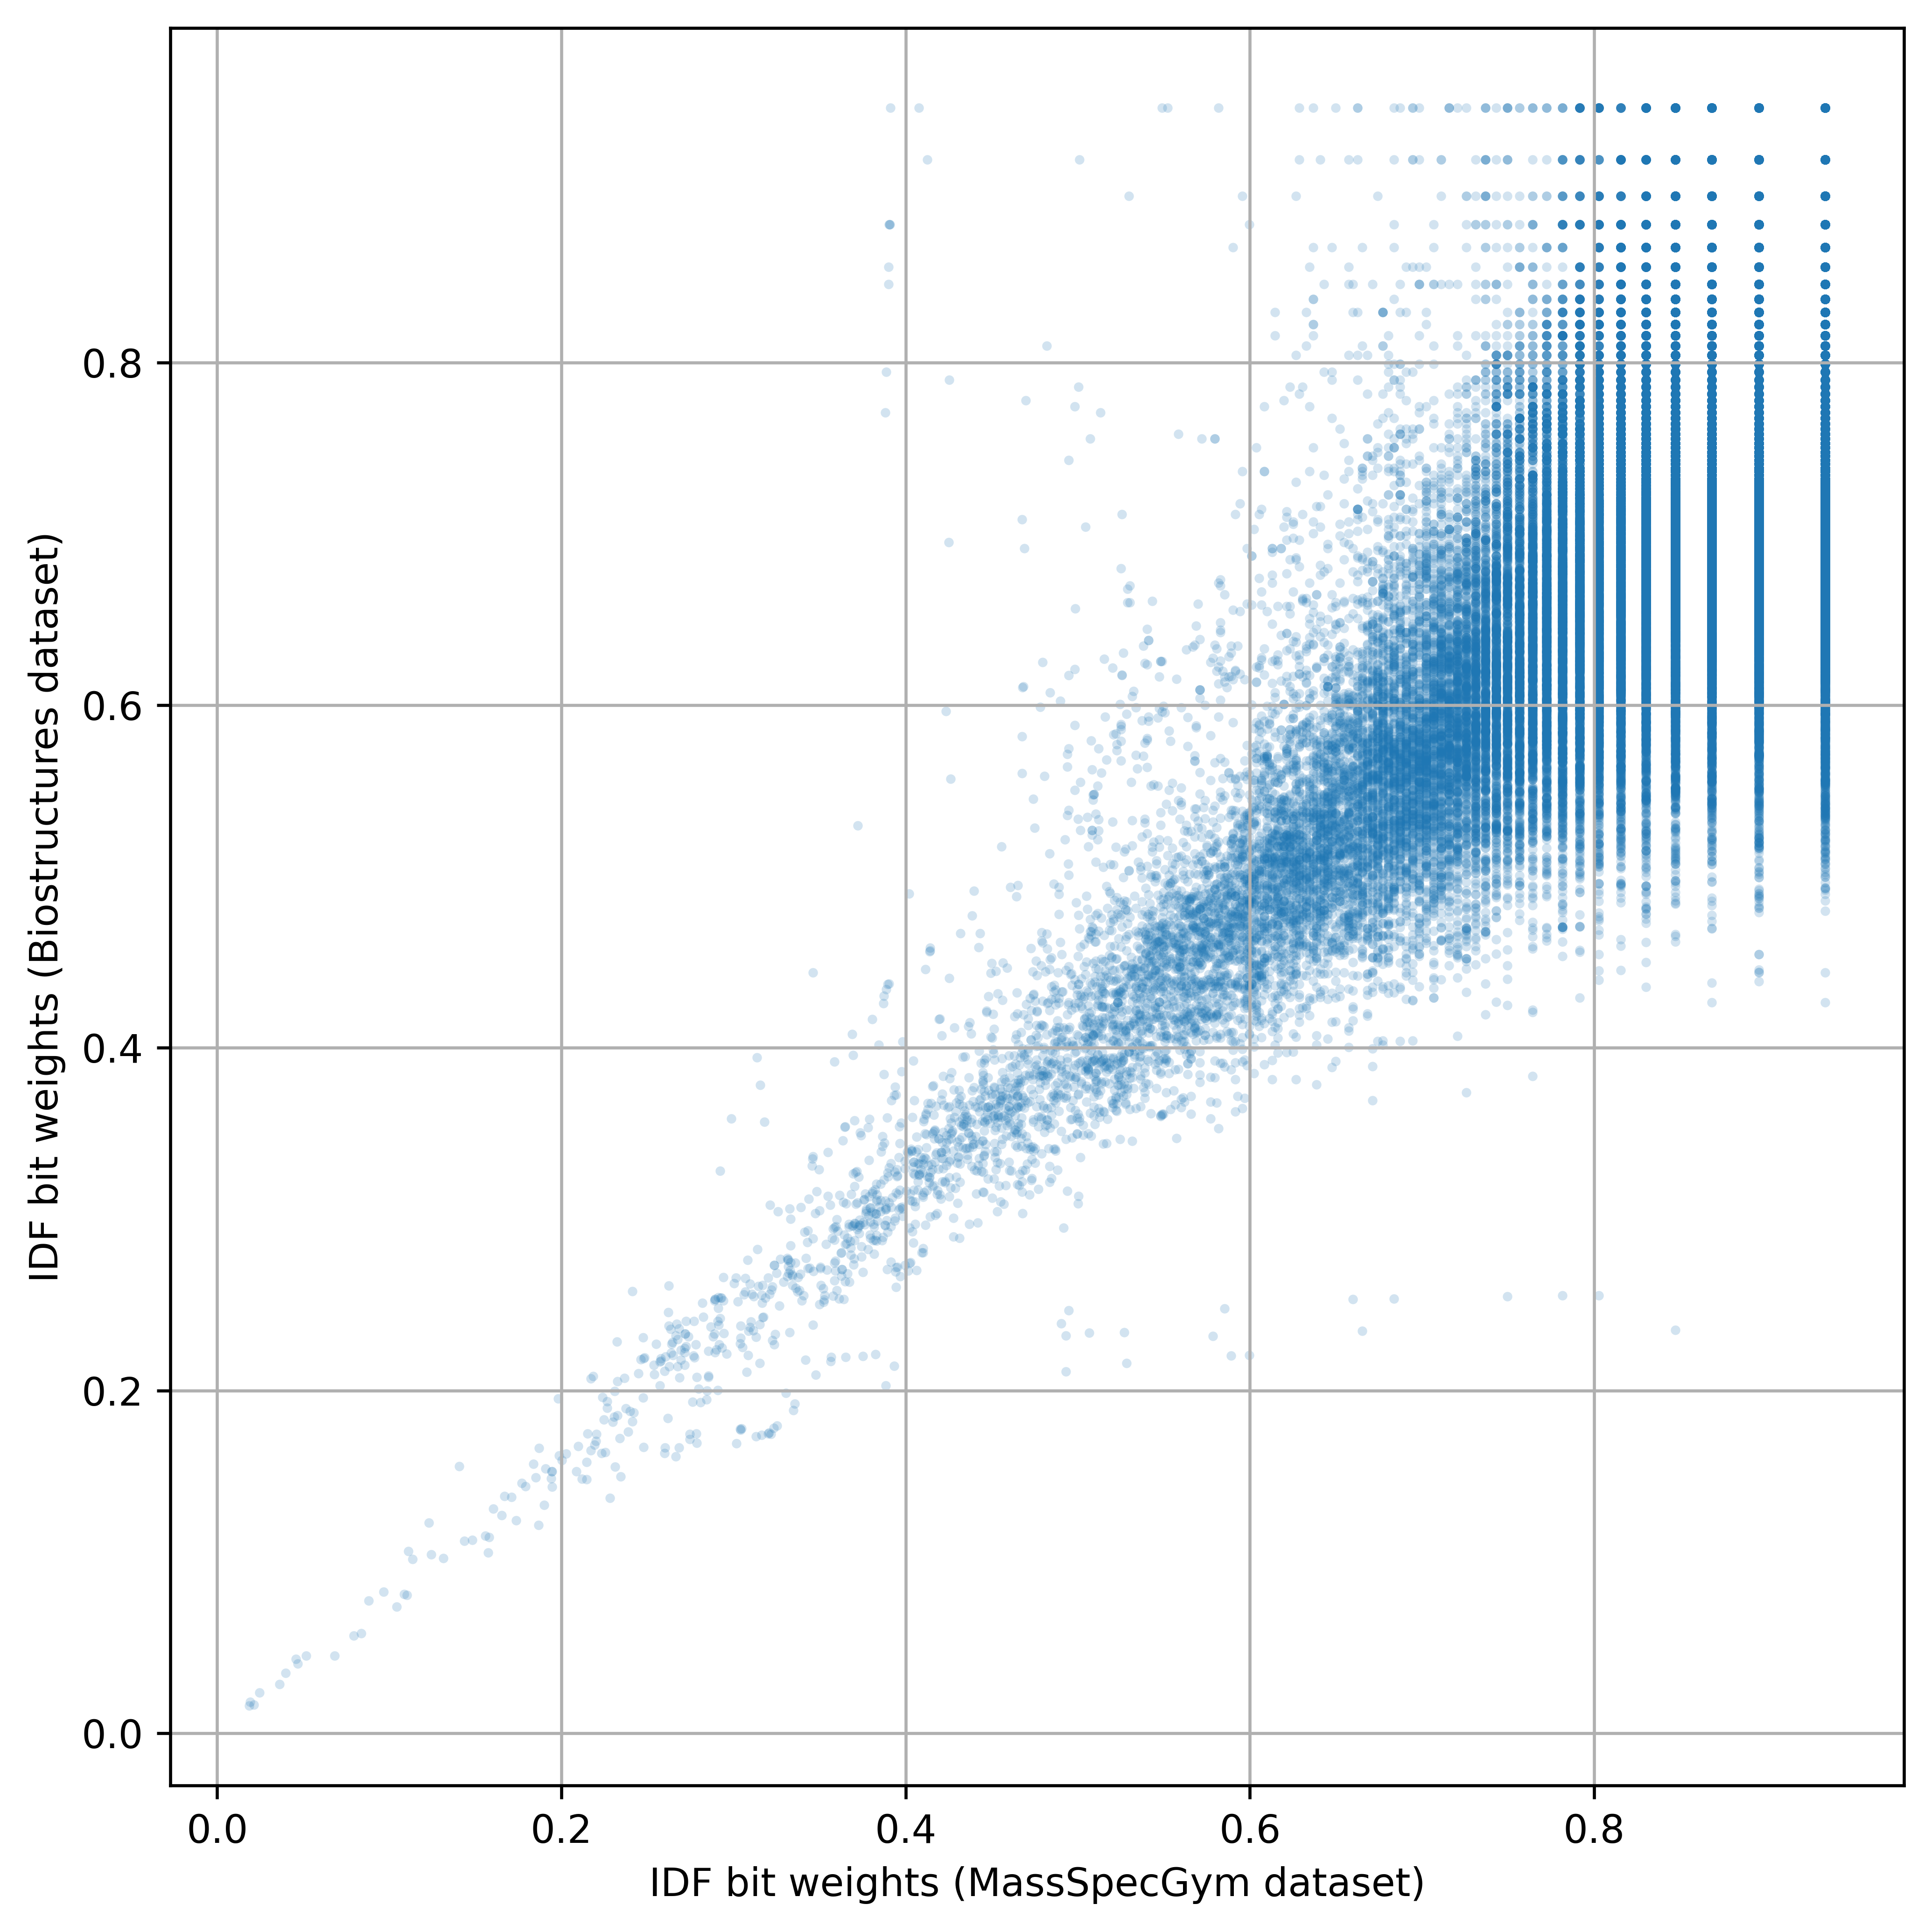

In [58]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=600)

ax.scatter(bit_weighing_ms2structures.loc[overlap],
           bit_weighing_biostructures.loc[overlap], s=6, alpha=0.2,
           linewidth=0,
          )

ax.set_xlabel("IDF bit weights (ms2structures dataset)")
ax.set_ylabel("IDF bit weights (Biostructures dataset)")
ax.grid(True)

plt.tight_layout()
plt.savefig("fig_scatter_plot_idf_weights.png", dpi=600)

In [59]:
from scipy import stats

res = stats.pearsonr(
    bit_weighing_ms2structures.loc[overlap],
    bit_weighing_biostructures.loc[overlap]
)
res

PearsonRResult(statistic=array([0.74994958]), pvalue=array([0.]))

In [62]:
diff1 = np.setdiff1d(
    bit_weighing_biostructures.index.values,
    bit_weighing_ms2structures.index.values)

diff1.shape

(880643,)

In [70]:
bit_weighing_biostructures.loc[diff1].describe()

,idf_weighing
count,880643.000000
mean,0.889371
std,0.069020
min,0.335518
25%,0.855691
50%,0.918527
75%,0.948596
max,0.948596


In [65]:
diff2 = np.setdiff1d(
    bit_weighing_ms2structures.index.values,
    bit_weighing_biostructures.index.values,
    )

diff2.shape

(9950,)

In [68]:
bit_weighing_ms2structures.loc[diff2].describe()

,idf_weighing
count,9950.000000
mean,0.904976
std,0.056365
min,0.501018
25%,0.895732
50%,0.934214
75%,0.934214
max,0.934214


In [72]:
(bit_weighing_ms2structures.loc[diff2] < 0.6).sum()

idf_weighing    51
dtype: int64